In [1]:
import os
import tarfile
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url
import torchvision.transforms as tt

%matplotlib inline

# Dataset Preparation

In [2]:
dataset_url = "http://files.fast.ai/data/cifar10.tgz"
download_url(dataset_url, '.')

with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train', 'labels.txt']
['horse', 'cat', 'ship', 'airplane', 'frog', 'automobile', 'bird', 'dog', 'deer', 'truck']


There are a few important changes we'll make while creating the PyTorch datasets:

1. **Use test set for validation**: Instead of setting aside a fraction (e.g. 10%) of the data from the training set for validation, we'll simply use the test set as our validation set. This just gives a little more data to train with. In general, once you have picked the best model architecture & hypeparameters using a fixed validation set, it is a good idea to retrain the same model on the entire dataset just to give it a small final boost in performance.
2. **Channel-wise data normalization**: We will normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel. As a result, the mean of the data across each channel is 0, and standard deviation is 1. Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values that others.
3. **Randomized data augmentations**: We will apply randomly chosen transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 32 x 32 pixels, and then flip the image horizontally with a 50% probability. Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it generalize better.

![data-augmentation](https://imgaug.readthedocs.io/en/latest/_images/cropandpad_percent.jpg)

In [3]:
 # Data transforms (normalization & data augmentation)

# stats = (means, std) across channels
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([
                         tt.RandomCrop(32, padding=4, padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(*stats, inplace=True)
])

valid_tfms = tt.Compose([
                         tt.ToTensor(),
                         tt.Normalize(*stats)
])

In [4]:
# loading & applying transformation to the dataset

train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', train_tfms)

In [5]:
batch_size = 400
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, 
                      num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size*2, 
                      num_workers=3, pin_memory=True)

In [6]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


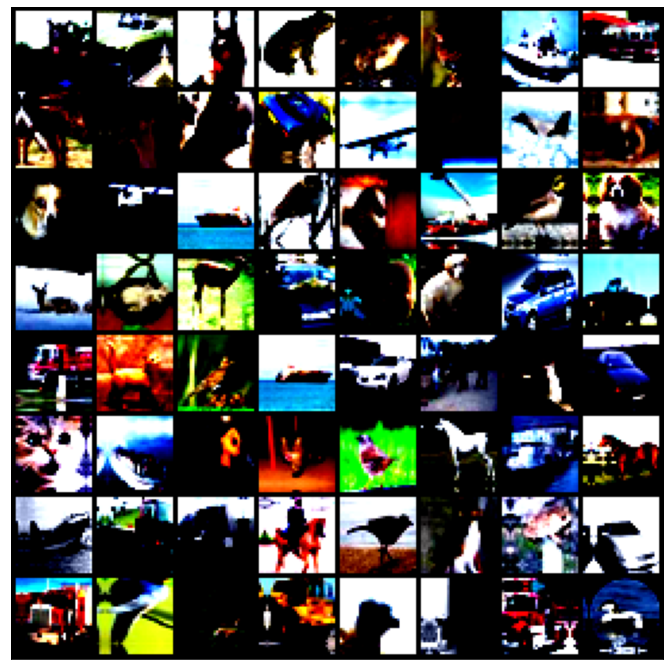

In [7]:
show_batch(train_dl)

# Using a GPU

In [8]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [9]:
device = get_default_device()
device

device(type='cuda')

In [10]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

# Model with Residual Blocks and Batch Normalization

One of the key changes to our CNN model this time is the addition of the resudial block, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers.

![](https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)

Here is a very simply Residual block:

In [11]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, 
                               stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, 
                               stride=1, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
         # ReLU can be applied before or after adding the input
        return self.relu2(out + x )

In [12]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break

del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([400, 3, 32, 32])


This seeming small change produces a drastic improvement in the performance of the model. Also, after each convolutional layer, we'll add a batch normalization layer, which normalizes the outputs of the previous layer. 

Go through the following blog posts to learn more:

* Why and how residual blocks work: https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec
* Batch normalization and dropout explained: https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd

We will use the ResNet9 architecture, as described in [this blog series](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet/) :

![resnet-9](https://github.com/lambdal/cifar10-fast/raw/master/net.svg?sanitize=true)

In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        inputs, labels = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, labels)
        acc = accuracy(outputs, labels)
        return {'loss': loss, 'acc': acc.detach()}
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def get_metrics_epoch_end(self, outputs, validation=True):
        if validation:
            loss_ = 'val_loss'
            acc_ = 'val_acc'
        else:
            loss_ = 'loss'
            acc_ = 'acc'

        batch_losses = [x[f'{loss_}'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x[f'{acc_}'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {f'{loss_}': epoch_loss.item(), f'{acc_}': epoch_acc.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        print(f"Epoch [{epoch+1}] -> lr: {result['lrs'][-1]:.5f} loss: {result['loss']:.4f}, acc: {result['acc']:.4f}, val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")

In [14]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [
              nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)
    ]

    if pool:
        layers.append(nn.MaxPool2d(kernel_size=2))
    
    return nn.Sequential(*layers)

In [15]:
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.conv1 = conv_block(in_channels, 64, pool=False) # 64 x 32 x 32
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 32 x 32
        self.res1 = nn.Sequential( # 128 x 16 x 16
            conv_block(128, 128, pool=False), 
            conv_block(128, 128, pool=False)
        )

        self.conv3 = conv_block(128, 256, pool=True) # 256 x 8 x 8
        self.conv4 = conv_block(256, 512, pool=True) # 512 x 4 x 4

        self.res2 = nn.Sequential( # 512 x 4 x 4
             conv_block(512, 512), 
             conv_block(512, 512)
        )
        
        self.classifier = nn.Sequential(
            nn.MaxPool2d(4), # 512 x 1 x 1 
            nn.Flatten(), # 512
            nn.Linear(512, num_classes) # 10
        )

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out        

In [16]:
model = to_device(ResNet9(3, 10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

# Training the model

Before we train the model, we're going to make a bunch of small but important improvements to our `fit` function:

* **Learning rate scheduling**: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and the one we'll use is called the **"One Cycle Learning Rate Policy"**, which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs. Learn more: https://sgugger.github.io/the-1cycle-policy.html

* **Weight decay**: We also use weight decay, which is yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.Learn more: https://d2l.ai/chapter_multilayer-perceptrons/weight-decay.html, https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab

* **Gradient clipping**: Apart from the layer weights and outputs, it also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping. Learn more: https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48


Let's define a `fit_one_cycle` function to incorporate these changes. We'll also record the learning rate used for each batch.

In [17]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.get_metrics_epoch_end(outputs=outputs, validation=True)

In [18]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [19]:
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    train_history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=max_lr,
                                                    epochs=epochs, 
                                                    steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        train_history = []
        lrs = []
        # Training Phase 
        model.train()
        for batch in train_loader:
            info = model.training_step(batch)
            loss = info['loss']
            # contains batch loss and acc for training phase
            train_history.append(info)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            lrs.append(get_lr(optimizer))
            scheduler.step()


        train_result = model.get_metrics_epoch_end(train_history, validation=False)
        val_result = evaluate(model, val_loader)
        result = {**train_result, **val_result}
        result['lrs'] = lrs
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [20]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.08355768769979477, 'val_loss': 2.310948133468628}]

We're now ready to train our model. Instead of SGD (stochastic gradient descent), we'll use the Adam optimizer which uses techniques like momentum and adaptive learning rates for faster training. You can learn more about optimizers here: https://ruder.io/optimizing-gradient-descent/index.html

In [21]:
epochs = 8
max_lr = 0.01 # https://github.com/davidtvs/pytorch-lr-finder
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [22]:
%%time
history = fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [1] -> lr: 0.00393 loss: 1.3252, acc: 0.5301, val_loss: 1.3477, val_acc: 0.5562
Epoch [2] -> lr: 0.00935 loss: 1.0013, acc: 0.6566, val_loss: 1.2322, val_acc: 0.6287
Epoch [3] -> lr: 0.00972 loss: 0.8002, acc: 0.7322, val_loss: 0.7766, val_acc: 0.7464
Epoch [4] -> lr: 0.00812 loss: 0.5831, acc: 0.8017, val_loss: 0.9129, val_acc: 0.7075
Epoch [5] -> lr: 0.00556 loss: 0.4656, acc: 0.8405, val_loss: 0.5714, val_acc: 0.8118
Epoch [6] -> lr: 0.00283 loss: 0.3493, acc: 0.8792, val_loss: 0.4348, val_acc: 0.8514
Epoch [7] -> lr: 0.00077 loss: 0.2552, acc: 0.9123, val_loss: 0.3390, val_acc: 0.8863
Epoch [8] -> lr: 0.00000 loss: 0.1848, acc: 0.9378, val_loss: 0.2922, val_acc: 0.9009
CPU times: user 54.9 s, sys: 15.9 s, total: 1min 10s
Wall time: 4min 6s


In [23]:
def plot_accuracies(history):
    plt.figure(figsize=(6, 5))
    train_acc = [r['acc'] for r in history]
    val_acc = [r['val_acc'] for r in history]
    plt.plot(train_acc, '-kx', label="train_acc")
    plt.plot(val_acc, '-rx', label="val_acc")
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. epochs')

In [24]:
def plot_losses(history):
    plt.figure(figsize=(6, 5))
    train_losses = [r['loss'] for r in history]
    val_losses = [r['val_loss'] for r in history]
    plt.plot(train_losses, '-kx', label="train_loss")
    plt.plot(val_losses, '-rx', label="val_loss")
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. epochs')

In [25]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

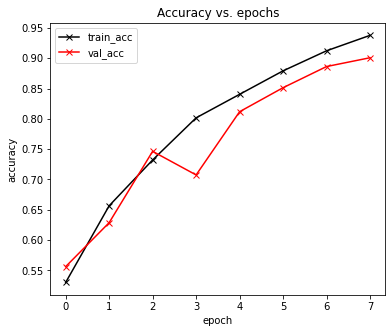

In [26]:
plot_accuracies(history)

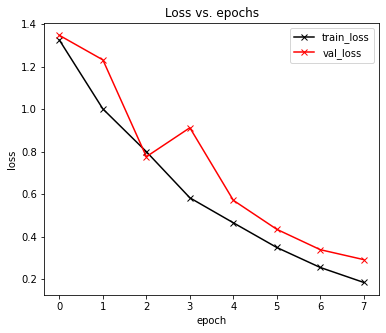

In [27]:
plot_losses(history)

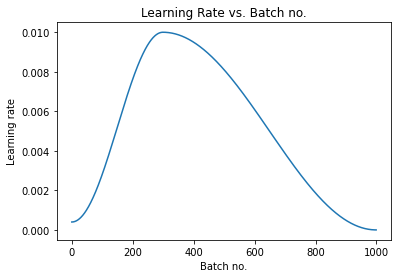

In [28]:
plot_lrs(history)

# Save model

In [29]:
torch.save(model.state_dict(), 'cifar10-resnet9.pth')